# ACS2 vs ACS2ER in Multiplexer

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lcs.metrics import population_metrics
from lcs.agents.EnvironmentAdapter import EnvironmentAdapter

import gym
import gym_multiplexer
from gym_multiplexer.utils import get_correct_answer
from lcs import Perception

from lcs.agents.acs2 import ACS2, Configuration as CFG_ACS2
from lcs.agents.acs2er import ACS2ER, Configuration as CFG_ACS2ER


# EXPERIMENT CONFIGURATION

In [2]:
CART_POLE = "CartPole-v0" 

EXPLORE_TRIALS = 5000
EXPLOIT_TRIALS = 100

# The size of ER replay memory buffer
ER_BUFFER_SIZE=2000
# The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
ER_BUFFER_MIN_SAMPLES=200
# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER=3


In [3]:
env = gym.make('CartPole-v0')

obs_adj_trials=20_000
bins = 6


In [4]:
%%time
print(f'Performing {obs_adj_trials} trials with random steps to collect ranges for observation points')

obs_arr = np.zeros((obs_adj_trials, 4))

for i in range(obs_adj_trials):
    env.reset()
    done = False
    while not done:
        obs, reward, done, _ = env.step(env.action_space.sample())
        obs_arr[i, :] = obs

env.close()

_high = obs_arr.max(axis=0)
_low = obs_arr.min(axis=0)

_range = _high - _low
_range

Performing 20000 trials with random steps to collect ranges for observation points
Wall time: 6.92 s


array([4.30162177, 6.6443159 , 0.54319009, 7.12160883])

## Metrics and helpers

In [5]:
class CartPoleObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, bins, low, val_range):
        super().__init__(env)
        self.bins = bins
        self.low = low
        self.range = val_range

    def observation(self, observation):
        return np.round(((observation - self.low) / self.range) * self.bins) \
            .astype(int) \
            .astype(str) \
            .tolist()

def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])


# collect more metrics
def cp_metrics(agent, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(agent.population)
    metrics.update(population_metrics(agent.population, env))

    return metrics


### Results arrays

ACS2 Experiments

In [7]:

### ACS2 ###
# Load desired environment
env = gym.make(CART_POLE)
cp = CartPoleObservationWrapper(env, bins, _low, _range)
# Create agent 
cfg_acs2 = CFG_ACS2(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=0.95,
            biased_exploration=0.5,
            beta=0.05,
            gamma=0.99,
            theta_exp=50,
            theta_ga=50,
            do_ga=False,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=10,
            user_metrics_collector_fcn=cp_metrics)
agent_acs2 = ACS2(cfg_acs2)
# Explore the environment
acs2_explore_metrics = agent_acs2.explore(cp, EXPLORE_TRIALS)
# Exploit the environment
acs2_exploit_metrics = agent_acs2.exploit(cp, EXPLOIT_TRIALS)


ACS2ER Experiments

In [8]:

### ACS2ER ###
# Load desired environment
env = gym.make(CART_POLE)
cp = CartPoleObservationWrapper(env, bins, _low, _range)
# Create agent ACS2ER
cfg_acs2er = CFG_ACS2ER(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=0.95,
            biased_exploration=0.05,
            beta=0.05,
            gamma=0.99,
            theta_exp=50,
            theta_ga=50,
            do_ga=False,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=10,
            er_buffer_size=ER_BUFFER_SIZE,
            er_min_samples=ER_BUFFER_MIN_SAMPLES,
            er_samples_number=ER_SAMPLES_NUMBER,
            user_metrics_collector_fcn=cp_metrics)
agent_acs2er = ACS2ER(cfg_acs2er)
# Explore the environment
acs2er_explore_metrics = agent_acs2er.explore(cp, EXPLORE_TRIALS)
# Exploit the environment
acs2er_exploit_metrics = agent_acs2er.exploit(cp, EXPLOIT_TRIALS)

    

E:\_ZSSE\other\conda\envs\pyalcs-experiments\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\_ZSSE\other\conda\envs\pyalcs-experiments\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1]:
# x_axis = range(EXPERIMENTS)

# plt.title("Multiplexer - EXPLORE")
# plt.scatter(x_axis, acs2_explore_results, c='r', label="ACS2")
# plt.scatter(x_axis, acs2er_explore_results, c='b', label="ACS2ER")
# plt.legend()
# plt.xlabel("experiment")
# plt.ylabel("avg. reward")
# plt.show()
# # plt.savefig(f"EXPLORE_{RUN}.png")
# plt.close()

# plt.title("Multiplexer - EXPLOIT")
# plt.scatter(x_axis, acs2_exploit_results, c='r', label="ACS2")
# plt.scatter(x_axis, acs2er_exploit_results, c='b', label="ACS2ER")
# plt.xlabel("experiment")
# plt.ylabel("avg. reward")
# plt.legend()
# plt.show()
# # plt.savefig(f"EXPLOIT_{RUN}.png")

In [9]:
RELIABLE_KEY = "reliable"

def extract_number_of_reliable_cl(metrics):
    return list(map(lambda m: m[RELIABLE_KEY], metrics))

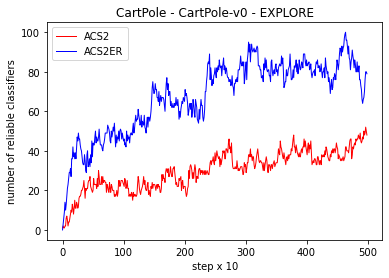

In [10]:
acs2_reliable = extract_number_of_reliable_cl(acs2_explore_metrics)
acs2er_reliable = extract_number_of_reliable_cl(acs2er_explore_metrics)

x_axis = range(len(acs2_reliable))

plt.title(f"CartPole - {CART_POLE} - EXPLORE")
plt.plot(x_axis, acs2_reliable, c='r', label="ACS2", linewidth=1.0)
plt.plot(x_axis, acs2er_reliable, c='b', label="ACS2ER", linewidth=1.0)
plt.legend()
plt.xlabel("step x 10")
plt.ylabel("number of reliable classifiers")
plt.show()
# plt.savefig(f"EXPLORE_{RUN}.png")

